In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
dados_treino = pd.read_csv('../data/processed/train_data.csv')
dados_teste = pd.read_csv('../data/processed/test_data.csv')

In [3]:
le_cat1 = LabelEncoder()
le_cat2 = LabelEncoder()
le_cat3 = LabelEncoder()
le_brand = LabelEncoder()

le_cat1 = le_cat1.fit(dados_treino.category_1)
le_cat2 = le_cat2.fit(dados_treino.category_2)
le_cat3 = le_cat3.fit(dados_treino.category_3)
le_brand = le_brand.fit(dados_treino.brand_name)

dados_treino['category_1'] = le_cat1.transform(dados_treino.category_1)
dados_treino['category_2'] = le_cat2.transform(dados_treino.category_2)
dados_treino['category_3'] = le_cat3.transform(dados_treino.category_3)
dados_treino['brand_name'] = le_brand.transform(dados_treino.brand_name)

In [4]:
dic_cat1 = dict(zip(le_cat1.classes_, le_cat1.transform(le_cat1.classes_)))
dic_cat2 = dict(zip(le_cat2.classes_, le_cat2.transform(le_cat2.classes_)))
dic_cat3 = dict(zip(le_cat3.classes_, le_cat3.transform(le_cat3.classes_)))
dic_brand = dict(zip(le_brand.classes_, le_brand.transform(le_brand.classes_)))


In [5]:
dados_teste = pd.read_csv('../data/processed/test_data.csv')
dados_teste['category_1'] = dados_teste['category_1'].map(dic_cat1).fillna(-1)
dados_teste['category_2'] = dados_teste['category_2'].map(dic_cat2).fillna(-1)
dados_teste['category_3'] = dados_teste['category_3'].map(dic_cat3).fillna(-1)
dados_teste['brand_name'] = dados_teste['brand_name'].map(dic_brand).fillna(-1)
dados_teste

,name,category_1,category_2,category_3,item_condition_id,brand_name,price,shipping,item_description,date,stock
0,women s motorcycle tshirt,10,104,751.0,3,1709.0,6.0,1,xl fits like a small,9-4-2018,8
1,alex and ani necklace,10,58,530.0,2,47.0,11.0,1,path of life alex and ani necklace in gold has...,25-1-2018,8
2,steve madden red lace up heels,10,88,629.0,2,3682.0,36.0,0,never been worn isn t true to size runs small,30-11-2018,9
3,men s black tuxedo,5,94,811.0,3,2795.0,54.0,0,worn a few times single pleated pants pants ar...,30-7-2018,7
4,red open back mermaid style dress xs,10,35,334.0,1,2795.0,316.0,0,this full length wine red mermaid style backle...,29-7-2018,34
...,...,...,...,...,...,...,...,...,...,...,...
444494,pink vs sleep shorts,10,5,687.0,3,2928.0,12.0,0,size small great condition barely ever worn to...,16-12-2018,7
444495,coach hand bag,10,112,392.0,3,926.0,86.0,0,this large black hobo coach is in a very good ...,15-11-2018,3
444496,waffle knit sweater forever,10,97,226.0,3,1384.0,14.0,0,great condition tags forever american apparel ...,2-3-2018,4
444497,dr dre beats solo,1,100,381.0,3,457.0,69.0,0,blue fits any head amazing sound no longer in use,19-3-2018,6


In [6]:
from xgboost import XGBRegressor

In [32]:
# model = xgboost.XGBRegressor(random_state=101, n_jobs=-1)
model = XGBRegressor(n_estimators=1000, 
                     max_depth=7,
                     grow_policy='lossguide', 
                     eta=0.1, 
                     subsample=0.7, 
                     colsample_bytree=0.8, 
                     random_state=101, 
                     n_jobs=-1)
X_treino = dados_treino[['category_1', 'category_2', 'category_3', 'brand_name', 'item_condition_id', 'shipping']]
y_treino = dados_treino['price']
model.fit(X_treino, y_treino)

pred = model.predict(dados_teste[['category_1', 'category_2', 'category_3', 'brand_name', 'item_condition_id', 'shipping']])
for i in range(len(pred)):
    if pred[i] < 3:
        pred[i] = 3
print('R² =', r2_score(dados_teste.price, pred))
print('RMSE =', mean_squared_error(dados_teste.price, pred)**0.5)
print('MAE =', mean_absolute_error(dados_teste.price, pred))

R² = 0.3601393113616167
RMSE = 30.688015361099747
MAE = 13.141685174350767


R² = 0.3601393113616167

RMSE = 30.688015361099747

MAE = 13.141685174350767

In [31]:
dados_teste.price.min()

3.0

In [27]:
print('R² =', r2_score(dados_teste.price, pred))
print('RMSE =', mean_squared_error(dados_teste.price, pred)**0.5)
print('MAE =', mean_absolute_error(dados_teste.price, pred))

R² = 0.35529784555820054
RMSE = 30.803896045771896
MAE = 13.022280064591879


In [33]:
from sklearn.metrics import mean_squared_log_error

print('RMSE =', mean_squared_log_error(dados_teste.price, pred))

RMSE = 0.35022052533453957


In [34]:
amostra = train_test_split(dados_teste,
                           test_size=1000,
                           random_state=101,
                           stratify=dados_teste[['category_1', 'item_condition_id']])[1]

In [35]:
pred = model.predict(amostra[['category_1', 'category_2', 'category_3', 'brand_name', 'item_condition_id', 'shipping']])
for i in range(len(pred)):
    if pred[i] < 3:
        pred[i] = 3

In [36]:
print('R² =', r2_score(amostra.price, pred))
print('RMSE =', mean_squared_error(amostra.price, pred)**0.5)
print('MAE =', mean_absolute_error(amostra.price, pred))

R² = 0.5149590048671143
RMSE = 29.101584640830595
MAE = 13.81266304206848


In [17]:
31**2

961

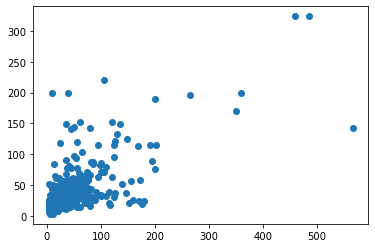

In [37]:
import matplotlib.pyplot as plt


plt.scatter(amostra.price, pred)